# TMDB 5000 Movies Dataset Project - Group ID: 6

Group Members:

* Bengisu Eren
- Dora Akbulut
* Gönül Ayöz
- İdil Kapıkıran

## Introduction

In today’s world many distractions await us, however we have no time to waste. We have to spend our time wisely and filter unnecessary information. A movie recommendation system is a remedy for busy people who try to reach as much as possible quality content. Also, movie streaming platforms want the audience to spend more time on the apps by making the platforms more interactive, user-based and responsive. Recommendation systems have been used in many different areas and have possible applications in marketing industry as well. In this project, we aim to develop a movie recommendation system.

### Problem Definition

  We want to build a movie recommendation system using clustering models and similarity functions. Given a list of movies, we aim to create a new list of movies using clustering models. Because we don't have user-specific information, we have to make recommendations based on content, genre, language, popularity, actors, revenue, keywords etc. In order to discover the relationships between movies we will make an exploratory data analysis. We will use our analysis to build and improve our models. For example, some keywords in the description of a movie or genre can be a significant parameter when recommending movies. We will analyse our data to find these sort of relationships between movies. 

  We have two questions that we want to answer in our work:

1. How are movies related by their numerical attributes? (e.g. budget, revenue and popularity)
2. How are movies related by their non-numerical attributes? (e.g. director, genre and cast)

### Downloading and importing data

In [ ]:
 ! pip install -q kaggle
 from google.colab import files
 files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"doraakbulut","key":"e33ca4404634c9271dc6b50db482bd27"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! mkdir my_data
! kaggle datasets download tmdb/tmdb-movie-metadata -p "/content/my_data" --unzip

 56% 5.00M/8.89M [00:00<00:00, 21.2MB/s]
100% 8.89M/8.89M [00:00<00:00, 35.3MB/s]


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
! pip install scikit-learn-extra
! pip install gower
%matplotlib inline

     |████████████████████████████████| 624kB 9.6MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for scikit-learn-extra: filename=scikit_learn_extra-0.1.0b2-cp36-cp36m-linux_x86_64.whl size=339575 sha256=df20f6aad6a4fe35acf2debade3b73a403a034e62e48c8ec637d07e0be96a439
  Stored in directory: /root/.cache/pip/wheels/04/01/0f/943bffb48bac048fa216b4325f1a6c939491ccb0ff500e08f4
Successfully built scikit-learn-extra
  Created wheel for gower: filename=gower-0.0.5-cp36-none-any.whl size=4233 sha256=5d5b7f1ec404766bb4fa1d6b1a2dd7f7738b199aab3041ef9ce950af24e49f98
  Stored in directory: /root/.cache/pip/wheels/c0/09/9b/072d54d6ced0f43a179852e3f09532d0131e25ff7cb4e5ee75
Successfully built gower


### Utilized Datasets

Our dataset is the TMDB Dataset and [this is the link to it.](https://www.kaggle.com/tmdb/tmdb-movie-metadata?select=tmdb_5000_movies.csv) It contains movies with many attributes such as director, revenue, budget, average votes etc.

The following code downloads the data from Kaggle and unzips it into a directory.

In [ ]:
dataset_credits = pd.read_csv("/content/my_data/tmdb_5000_credits.csv")
dataset_movies = pd.read_csv("/content/my_data/tmdb_5000_movies.csv")

In [ ]:
df_credits = dataset_credits.copy(deep=True)
df_movies = dataset_movies.copy(deep=True)

We will join the credits dataset to the movies dataset and examine them together.

In [ ]:
df_credits.head(2)

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."


In [ ]:
df_credits = df_credits.drop(columns=["title"], axis=1)
df_movies = pd.concat([df_movies, df_credits], axis = 1)

In [ ]:
df_movies.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,movie_id,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,19995,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,285,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."


In [ ]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

#### Data types
Our dataset has 23 features, 8 of which are numeric and 15 of them are strings. There are a total of 4803 entries in the dataset.

The following features are not of importance for the aim of our project. Therefore they will be dropped from the dataset: 
- *homepage*
- *id*(duplicate)
- *status* (also, rows with the status "Rumored" and "Post Production" will be dropped too, since they are irrelevant as well)
- *original title* (since we already have the english title)
- *overview*
- *crew* (but the director will be useful, so we will use this feature to extract a new feature)
- *spoken_languages*
- *production_countries*
- *original_language*

In [ ]:
df_movies["status"].value_counts()

Released           4795
Rumored               5
Post Production       3
Name: status, dtype: int64

In [ ]:
df_movies = df_movies.drop(df_movies[df_movies['status'] == "Rumored"].index, axis=0)
df_movies = df_movies.drop(df_movies[df_movies["status"] == "Post Production"].index, axis=0)
df_movies = df_movies.drop(columns=["status", "homepage", "id", "original_title", 
                                    "overview", "spoken_languages", 
                                    "tagline", "production_countries", "original_language"], axis=1)

The following are the categorical features:
- *genres*
- *keywords*
- *production companies*
- *cast*
- *crew*

The following are the continuous features:
- *budget*
- *popularity*
- *revenue*
- *runtime*
- *vote average*

The following are the discrete features:
- *vote count*

The following are the ordinal features:
- *release date* (we will use date only as year in the coming parts)

#### Distributions

Now, we will take a look at the distributions of various features.

In [ ]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4795 entries, 0 to 4802
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4795 non-null   int64  
 1   genres                4795 non-null   object 
 2   keywords              4795 non-null   object 
 3   popularity            4795 non-null   float64
 4   production_companies  4795 non-null   object 
 5   release_date          4794 non-null   object 
 6   revenue               4795 non-null   int64  
 7   runtime               4793 non-null   float64
 8   title                 4795 non-null   object 
 9   vote_average          4795 non-null   float64
 10  vote_count            4795 non-null   int64  
 11  movie_id              4795 non-null   int64  
 12  cast                  4795 non-null   object 
 13  crew                  4795 non-null   object 
dtypes: float64(3), int64(4), object(7)
memory usage: 561.9+ KB


In [ ]:
df_movies.describe()

,budget,popularity,revenue,runtime,vote_average,vote_count,movie_id
count,4.795000e+03,4795.000000,4.795000e+03,4793.000000,4795.000000,4795.000000,4795.000000
mean,2.909267e+07,21.527415,8.239771e+07,106.915084,6.093306,691.360792,57051.887800
std,4.073962e+07,31.831547,1.629583e+08,22.570343,1.190313,1235.298140,88593.489117
min,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,5.000000
25%,8.000000e+05,4.723880,0.000000e+00,94.000000,5.600000,54.000000,9010.500000
50%,1.500000e+07,12.963328,1.925587e+07,104.000000,6.200000,236.000000,14585.000000
75%,4.000000e+07,28.352222,9.311911e+07,118.000000,6.800000,738.000000,58533.000000
max,3.800000e+08,875.581305,2.787965e+09,338.000000,10.000000,13752.000000,459488.000000


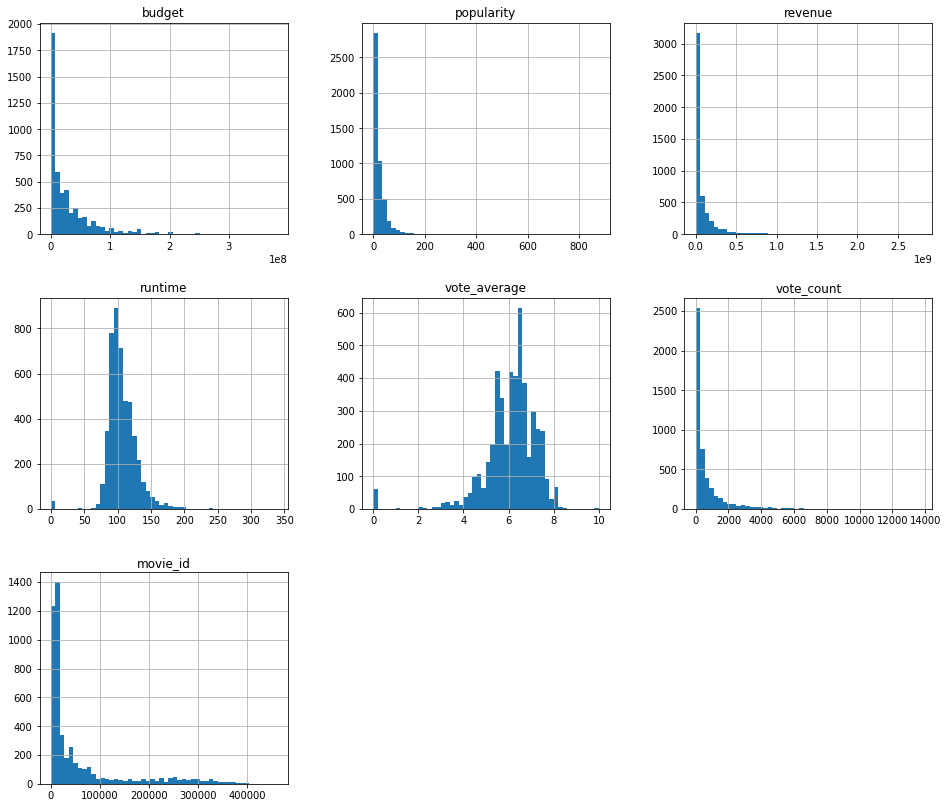

In [ ]:
df_movies.hist(bins = 50, figsize = (16, 14), ) #this method shows the histograms for each numerical attribute
plt.show()

It looks like most of the numerical features are highly skewed, which is highly expected as there are some blockbuster movies that dominate the movie industry. *Vote average* is slightly skewed to left in contrast with most of the features.

In [ ]:
sum(df_movies.duplicated())

0

### The Dataset


Let's check the NaN values.

In [ ]:
df_movies.isna().sum()

budget                  0
genres                  0
keywords                0
popularity              0
production_companies    0
release_date            1
revenue                 0
runtime                 2
title                   0
vote_average            0
vote_count              0
movie_id                0
cast                    0
crew                    0
dtype: int64

Now, we drop the NaN values because they are so few in number.

In [ ]:
df_movies = df_movies.dropna(axis = 0)

Before moving on to explorative data analysis, we need to work on several columns in order to make use of them. These columns are:
- *genres*
- *keywords*
- *production companies*
- *cast*
- *crew*

For example, the column *genres* is in the following format:

In [ ]:
df_movies["genres"][1]

'[{"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 28, "name": "Action"}]'

Let's make categoric features out of the *genres* feature which is in a dictionary format.

In [ ]:
genre_list = ['Adventure', 'Science Fiction', 'Fantasy', 'Crime',
              'Western', 'Family', 'Animation','War',
              'Mystery','Romance','TV Movie','Action', 'Thriller',
              'Comedy','Drama' , 'History', 'Music', 'Horror', 'Documentary', 'Foreign']

def assign_genre(genres):
  if (element in genres):
    return True
  else:
    return False


for element in genre_list:
  df_movies[element] = df_movies["genres"].apply(assign_genre)

df_movies.head(2)

,budget,genres,keywords,popularity,production_companies,release_date,revenue,runtime,title,vote_average,vote_count,movie_id,cast,crew,Adventure,Science Fiction,Fantasy,Crime,Western,Family,Animation,War,Mystery,Romance,TV Movie,Action,Thriller,Comedy,Drama,History,Music,Horror,Documentary,Foreign
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",2009-12-10,2787965087,162.0,Avatar,7.2,11800,19995,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",True,True,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",2007-05-19,961000000,169.0,Pirates of the Caribbean: At World's End,6.9,4500,285,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False


There are too many keywords for processing and generating features. We will make use of the *keywords* feature later on.

Let's change the release date feature into datetime object.

In [ ]:
df_movies['release_date'] = pd.to_datetime(df_movies['release_date'])
df_movies['year'] = df_movies['release_date'].dt.year
df_movies = df_movies.drop("release_date", axis = 1)

Now, we extract a new feature *director* from the *crew* column.

In [ ]:
def extract_director(crew):
  if (crew  == "[]"):
    return None
  mylist = crew[crew.find("Director\""):crew.find("}", crew.find("Director\""))].split("\"")
  if (mylist[0] != "Director"):
    return None
  else:
    return mylist[4]

df_movies["director"] = df_movies["crew"].apply(extract_director)
# df_movies[df_movies["director"][0] != "Director"]
df_movies = df_movies.dropna(subset = ["director"])
df_movies.drop("crew", axis = 1, inplace = True)

And we use the *director* column to create a new feature that will give the number of movies that director has directed.

In [ ]:
def assign_director_movie_count(col, dir_df):
  return dir_df[dir_df.index == col][0]

movie_counts = df_movies["director"].value_counts()
df_movies["director_movie_count"] = df_movies["director"].apply(assign_director_movie_count, dir_df = movie_counts)

Let's extract the first three actors or actresses that appear in the *cast* column.

In [ ]:
df_movies['cast'][1]

'[{"cast_id": 4, "character": "Captain Jack Sparrow", "credit_id": "52fe4232c3a36847f800b50d", "gender": 2, "id": 85, "name": "Johnny Depp", "order": 0}, {"cast_id": 5, "character": "Will Turner", "credit_id": "52fe4232c3a36847f800b511", "gender": 2, "id": 114, "name": "Orlando Bloom", "order": 1}, {"cast_id": 6, "character": "Elizabeth Swann", "credit_id": "52fe4232c3a36847f800b515", "gender": 1, "id": 116, "name": "Keira Knightley", "order": 2}, {"cast_id": 12, "character": "William \\"Bootstrap Bill\\" Turner", "credit_id": "52fe4232c3a36847f800b52d", "gender": 2, "id": 1640, "name": "Stellan Skarsg\\u00e5rd", "order": 3}, {"cast_id": 10, "character": "Captain Sao Feng", "credit_id": "52fe4232c3a36847f800b525", "gender": 2, "id": 1619, "name": "Chow Yun-fat", "order": 4}, {"cast_id": 9, "character": "Captain Davy Jones", "credit_id": "52fe4232c3a36847f800b521", "gender": 2, "id": 2440, "name": "Bill Nighy", "order": 5}, {"cast_id": 7, "character": "Captain Hector Barbossa", "credit_

In [ ]:
from ast import literal_eval
df_movies = df_movies.drop(df_movies[df_movies['cast'] == "[]"].index, axis=0)
df_movies['cast'] = df_movies['cast'].apply(literal_eval)
df_movies['cast_size'] = df_movies['cast'].apply(lambda x: len(x))

df_movies['cast'] = df_movies['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
df_movies['cast'] = df_movies['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)


In [ ]:
cast_list = ["cast_1", "cast_2", "cast_3"]

def extract_cast(cast, i):
  if (len(cast) > i):
    return cast[i]
  else:
    return None

n = 0
for cast in cast_list:
  df_movies[cast] = df_movies["cast"].apply(extract_cast, i = n)
  n += 1;

df_movies = df_movies.dropna(subset = ["cast_2", "cast_3"])
df_movies.drop(["cast"], inplace = True, axis = 1)

Now we extract two new features. The first will be *director_movie_count* and it will be the number of movies that a director of a movie has in the dataset. We believe that this will be another measure of the popularity or productivity of a director. And the second will be the *cast_movie_count*, it is very similar to the former one and gives us the number of movies the cast of a movie has appeared in total.

In [ ]:
def assign_director_movie_count(col, dir_df):
  return dir_df[dir_df.index == col][0]

movie_counts = df_movies["director"].value_counts()
df_movies["director_movie_count"] = df_movies["director"].apply(assign_director_movie_count,
                                                                dir_df = movie_counts)

In [ ]:
def assign_cast_movie_count(row, cast_df_1, cast_df_2, cast_df_3):
  cast_list = ["cast_1", "cast_2", "cast_3"]
  sum = 0
  for c in cast_list:
    if (row[c] in cast_df_1):
      sum += cast_df_1[row[c]]
    if (row[c] in cast_df_2):
      sum += cast_df_2[row[c]]
    if (row[c] in cast_df_3):
      sum += cast_df_3[row[c]]
  return sum

In [ ]:
cast1_df = df_movies["cast_1"].value_counts()
cast2_df = df_movies["cast_2"].value_counts()
cast3_df = df_movies["cast_3"].value_counts()

In [ ]:
df_movies["cast_movie_count"] = df_movies.apply(assign_cast_movie_count,
                                                cast_df_1 = cast1_df, cast_df_2 = cast2_df,
                                                cast_df_3 = cast3_df, axis=1)

We also want to extract the movie production companies for each movie.

In [ ]:
df_movies = df_movies.drop(df_movies[df_movies['production_companies'] == "[]"].index, axis=0)
df_movies['production_companies'] = df_movies['production_companies'].apply(literal_eval)

df_movies['production_companies'] = df_movies['production_companies'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
df_movies['production_companies'] = df_movies['production_companies'].apply(lambda x: x[:3] if len(x) >=3 else x)


In [ ]:
prod_list = ["production_companies_1", "production_companies_2", "production_companies_3"]

def extract_prod(prod, i):
  if (len(prod) > i):
    return prod[i]
  else:
    return None

n = 0
for prod in prod_list:
  df_movies[prod] = df_movies["production_companies"].apply(extract_prod, i = n)
  n += 1;

#df_movies = df_movies.dropna(subset = ["production_companies_2", "production_companies_3"])
df_movies.drop(["production_companies"], inplace = True, axis = 1)

In [ ]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4431 entries, 0 to 4802
Data columns (total 41 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   budget                  4431 non-null   int64  
 1   genres                  4431 non-null   object 
 2   keywords                4431 non-null   object 
 3   popularity              4431 non-null   float64
 4   revenue                 4431 non-null   int64  
 5   runtime                 4431 non-null   float64
 6   title                   4431 non-null   object 
 7   vote_average            4431 non-null   float64
 8   vote_count              4431 non-null   int64  
 9   movie_id                4431 non-null   int64  
 10  Adventure               4431 non-null   bool   
 11  Science Fiction         4431 non-null   bool   
 12  Fantasy                 4431 non-null   bool   
 13  Crime                   4431 non-null   bool   
 14  Western                 4431 non-null   

We will drop production companies 2 and 3, because there are too many null values.

In [ ]:
df_movies.drop(["production_companies_2"], inplace = True, axis = 1)
df_movies.drop(["production_companies_3"], inplace = True, axis = 1)

Let's get the weighted average votes for movies because this might be a more meaningful way to look at our data.

In [ ]:
v = df_movies["vote_count"]
R = df_movies["vote_average"]
c = df_movies["vote_average"].mean()
m = df_movies["vote_count"].quantile(0.7)

df_movies["weighted_average"] = (R * v + c * m) / (v + m)

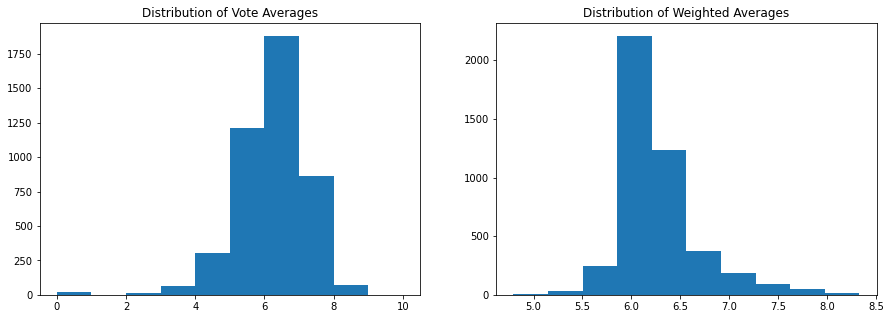

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15, 5))
ax[0].hist(df_movies["vote_average"])
ax[0].set_title("Distribution of Vote Averages")

ax[1].hist(df_movies["weighted_average"])
ax[1].set_title("Distribution of Weighted Averages")
plt.show()

## Data Exploration
We will not be splitting our data in train and test because we will use clustering algorithms. If we find a way to make use of test data in our future work, we might consider using it too.

In [ ]:
X_train=df_movies.copy()

In [ ]:
X_train.head(2)

,budget,genres,keywords,popularity,revenue,runtime,title,vote_average,vote_count,movie_id,Adventure,Science Fiction,Fantasy,Crime,Western,Family,Animation,War,Mystery,Romance,TV Movie,Action,Thriller,Comedy,Drama,History,Music,Horror,Documentary,Foreign,year,director,director_movie_count,cast_size,cast_1,cast_2,cast_3,cast_movie_count,production_companies_1,weighted_average
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",150.437577,2787965087,162.0,Avatar,7.2,11800,19995,True,True,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,2009,James Cameron,7,83,Sam Worthington,Zoe Saldana,Sigourney Weaver,36,Ingenious Film Partners,7.146547
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",139.082615,961000000,169.0,Pirates of the Caribbean: At World's End,6.9,4500,285,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,2007,Gore Verbinski,7,34,Johnny Depp,Orlando Bloom,Keira Knightley,56,Walt Disney Pictures,6.808643


As we have seen before, our data is skewed, now we will remove outliers as we visualize them.

In [ ]:
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
X_train_clean = X_train.copy()

numerical_list = ['revenue', 'popularity','budget', 'runtime', 'vote_count', "weighted_average", "vote_average", "director_movie_count", "cast_movie_count"]


X_train_clean.loc[:, ("budget")] = X_train["budget"].replace(0, X_train["budget"].mean())
Q1 = X_train_clean["budget"].quantile(0.25)
Q3 = X_train_clean["budget"].quantile(0.75)
IQR = Q3 - Q1
X_train_clean=X_train.loc[(X_train["budget"] >=Q1- 1.5*IQR) & (X_train["budget"]<=Q3+ 1.5*IQR)]



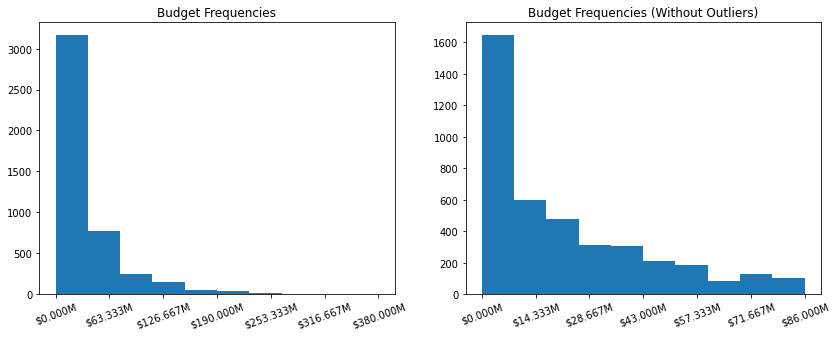

In [ ]:
max=X_train["budget"].max()
max_clean=X_train_clean["budget"].max()

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (14,5))

ax1.hist(X_train["budget"])
ax2.hist([X_train_clean["budget"]])

xlocs = np.linspace(0, max ,7)
xlocs_clean = np.linspace(0, max_clean ,7)
xticks_labels = [f"${xloc/10**6:.3f}M" for xloc in xlocs]
xticks_labels_clean = [f"${xloc/10**6:.3f}M" for xloc in xlocs_clean]


ax1.set_title("Budget Frequencies")
ax1.set_xticks(xlocs)
ax1.set_xticklabels(xticks_labels, rotation=20)

ax2.set_xticks(xlocs_clean)
ax2.set_xticklabels(xticks_labels_clean, rotation=20)
ax2.set_title("Budget Frequencies (Without Outliers)")

plt.show()

The following is genres in our dataframe and their appearance times.

In [ ]:
for genre in genre_list:
  print(genre, X_train_clean[(X_train_clean[genre] == True)].shape)

Adventure (540, 40)
Science Fiction (409, 40)
Fantasy (306, 40)
Crime (641, 40)
Western (74, 40)
Family (385, 40)
Animation (161, 40)
War (129, 40)
Mystery (314, 40)
Romance (814, 40)
TV Movie (7, 40)
Action (886, 40)
Thriller (1116, 40)
Comedy (1501, 40)
Drama (2026, 40)
History (174, 40)
Music (175, 40)
Horror (481, 40)
Documentary (63, 40)
Foreign (16, 40)


We categorize the budgets to make the analyzing and visualization easier.

In [ ]:
def categorize_budget(budget):
  if budget < 2.909267e+07:
    return 'Low'
  elif 2.909267e+07 <= budget <= 42268587.8827761	:
    return 'Medium'
  else:
    return 'High'


X_train_clean['Budget Category'] = X_train_clean['budget'].astype(int).apply(categorize_budget)

duration_groups = X_train_clean.groupby(by = 'Budget Category')

value_dict = {}
for key, vals in duration_groups.groups.items():
  value_dict[key] = X_train_clean.loc[vals]['vote_average'].dropna().values

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


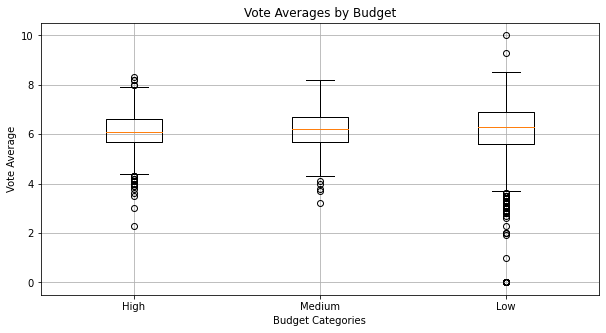

In [ ]:
ratings = sorted(value_dict.items(), key=lambda x: np.median(x[1]))
fig, ax = plt.subplots(figsize=(10,5))

ax.boxplot([val[1] for val in ratings])
ax.set_xticklabels([rating[0] for rating in ratings])
ax.set_ylabel('Vote Average')
ax.set_xlabel('Budget Categories')
ax.set_title('Vote Averages by Budget')
ax.grid()
plt.show();

It seems like, there is no difference in terms of vote average after removing outliers. The relationships between vote averages and budget categories do not tell us much about movies.

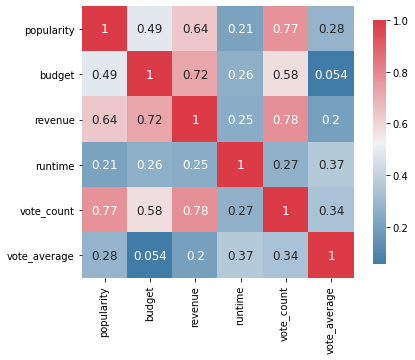

In [ ]:
import seaborn as sns
corr = df_movies[['popularity','budget','revenue','runtime','vote_count','vote_average']].corr()
_, ax = plt.subplots(figsize = (7,5))
cmap = sns.diverging_palette( 240 , 10 , as_cmap = True )
_ = sns.heatmap(corr,cmap = cmap,square=True, cbar_kws={ 'shrink' : .9 }, ax=ax, annot = True, annot_kws = { 'fontsize' : 12 })

There is a strong correlation betweeen: 

*   vote_count and popularity and revenue
*   revenue and budget

The correlation between budget and popularity is not as strong as the correlation between revenue and budget. This relations gives us clues about the differences between movies.

The correlation between budget and vote aveerage is almost zero. This is in line with our previous inferences about them from boxplots above.








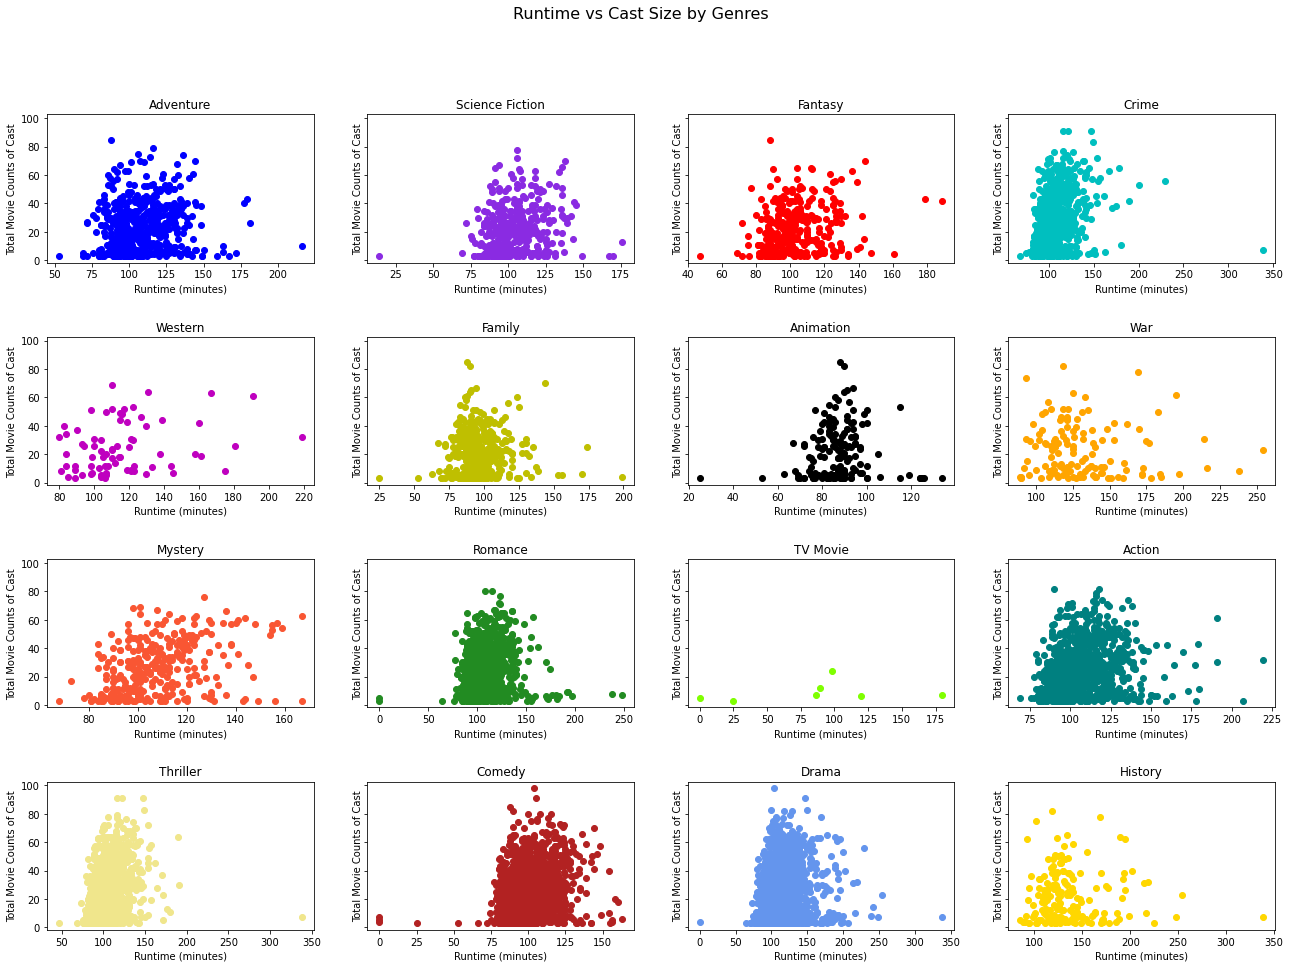

In [ ]:
fig, ax = plt.subplots(4,4, figsize = (22,15), sharey = True)
fig.suptitle('Runtime vs Cast Size by Genres', fontsize=16)
plt.subplots_adjust(hspace=0.5)

color_list = ["b", "blueviolet", "r", "c", "m", "y", "k", "orange",
              "#F95633","forestgreen","chartreuse","teal","khaki","firebrick","cornflowerblue","gold"]
i = 0
j = 0
k = 0
for i in range(4):
  for j in range(4):
    temp_df = X_train_clean[X_train_clean[genre_list[k]] == True]
    ax[i][j].plot(temp_df["runtime"], temp_df["cast_movie_count"],
                  marker='.', linestyle='', ms=12, label=genre, c=color_list[(k) % 16])
    ax[i][j].set_title(genre_list[k])
    ax[i][j].set_xlabel("Runtime (minutes)")
    ax[i][j].set_ylabel("Total Movie Counts of Cast")
    k+=1

We can see from these graphs that most genres are clustered, it will be important for us while grouping movies.


We categorized the vote counts into 4 groups to make analyzing and visualization easier.

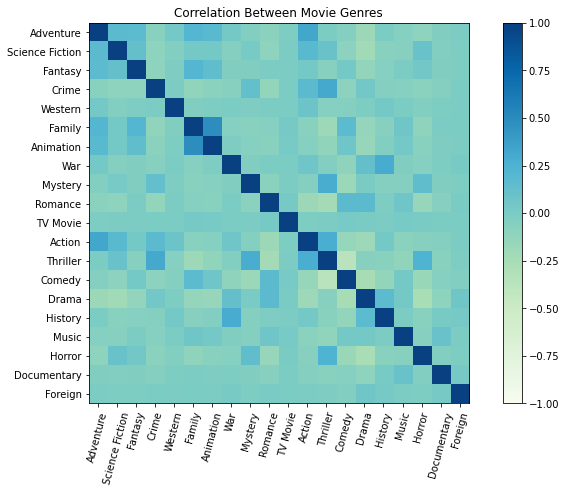

In [ ]:
corrs=X_train_clean[genre_list].corr()
fig= plt.figure(figsize=(12,7))
plt.imshow(corrs, cmap="GnBu", vmin = -1, vmax = 1)
plt.colorbar()
plt.title("Correlation Between Movie Genres")
plt.xticks(range(len(corrs)),corrs.columns, rotation=75)
plt.yticks(range(len(corrs)),corrs.index)
plt.show()

Above graph show us which genres are used in movies together. 
From the graph it could be said that 
* Animation and Family 

movies are **highly** correlated

* Action and Adventure
* Thriller and Crime
* Thriller and Mystery
* History and War
* Horror and Thriller
* Thriller and Action
* Horror and Sci-Fi
* Horror and Mystery
* Comedy and Romance
* Comedy and Drama
* Comedy and Family

are **slightly** correlated 

* Comedy and Thriller 

movies are the **least** correlated.

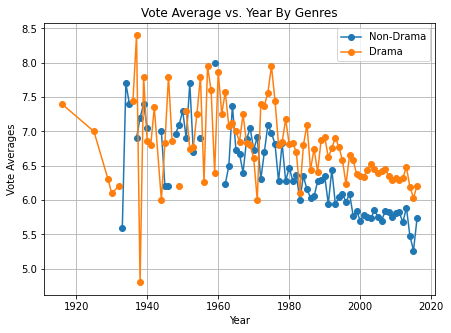

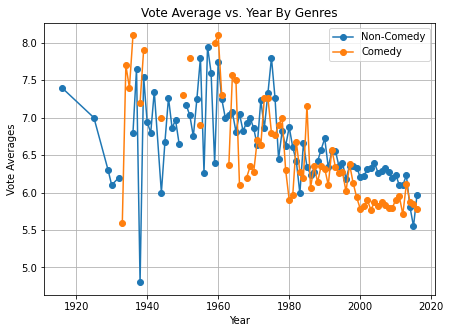

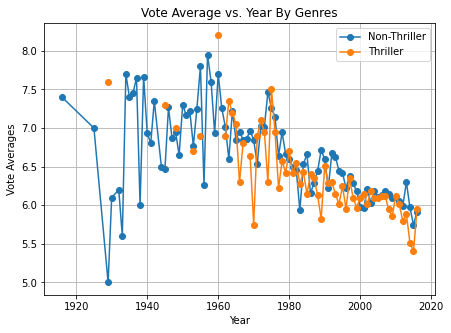

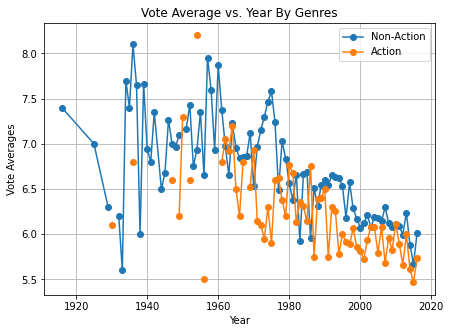

In [ ]:
mini_genre_list = [["Drama", "Comedy"], ["Thriller", "Action"]]
for a in range(2):
  for b in range(2):
    groups = X_train_clean.groupby(by = ["year",mini_genre_list[a][b]])
    ax[a][b] = groups["vote_average"].mean().unstack().plot(figsize = (7, 5), grid = True,
                                                  xlabel="Year", ylabel = "Vote Averages",
                                                  marker = "o",
                                                  title = "Vote Average vs. Year By Genres")
    ax[a][b].legend(["Non-"+mini_genre_list[a][b],mini_genre_list[a][b]])
plt.show()

Here we can see some genres' vote averages through years. Some genres got lower ratings compared to others in some years. For example, drama movies were rated high after 2000.

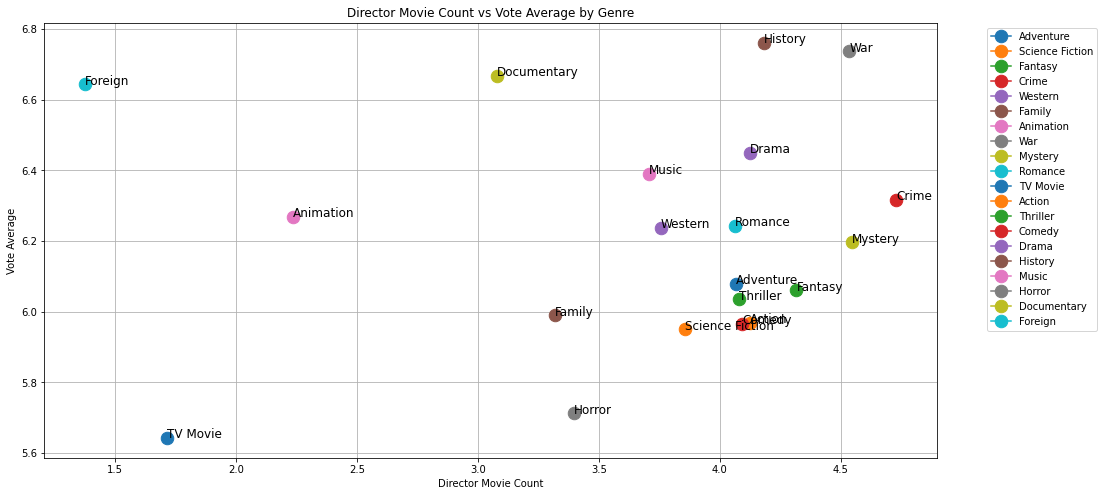

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (16,8))
for genre in genre_list:
    temp_df = X_train_clean[X_train_clean[genre] == True]
    genre_group = temp_df.groupby(genre)[["director_movie_count", "vote_average"]].mean()
    genre_group.plot(x="director_movie_count", y="vote_average", kind="line", ax=ax, marker='.', ms=25, label=genre)
    ax.annotate(genre, (genre_group.director_movie_count, genre_group.vote_average), xycoords = "data", fontsize = 12)

ax.set_title("Director Movie Count vs Vote Average by Genre")
ax.set_xlabel("Director Movie Count")
ax.set_ylabel("Vote Average")

ax.grid(True)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

It can be clearly seen from this scatter graph that genres are very important to identify the relationships between movies, especially for foreign, animation, documentary and tv movies. Vote averages and director movie counts are also informative, because different genres have different types of directors.




## Machine Learning Models
We implement a K-Means Clustering model, an Agglomerative Clustering model using Gower's Distance, a K-Means model with Principal Component Analysis and a Cosine Similarity Function in order to find movies that are alike.

Using K-Means, Agglomerative with Gower's Distance and K-Means with PCA; we aim to discover how we can find movies related with their numerical and binary attributes. These attributes include budget, revenue, runtime, vote counts, weighted average, vote average, year and genres.

Using Cosine Similarity Function, we aim to discover how we can find movies related with their categorical attributes. We aim to measure how similar movies are based on their directors, starring actors, production companies and genres.

### Implementation

We will discuss and evaluate our models as we implement them. And later on, we will compare them and elaborate on their performances.

#### KMeans Model


We can only use our numeric values in our model. Therefore we must process our dataset. 

We will not include our binary data, because KMeans clustering works well only with continuous data. Therefore we wil drop them along with the categorical features from our data.

Our numeric features are: budget, popularity, revenue, runtime, vote_average, vote_count, year, director_movie_count, cast_size, cast_movie_count, weighted_average

In [ ]:
X_train_num= X_train.drop(["genres", "keywords","title","director","cast_1","cast_2","cast_3","production_companies_1"], axis = 1)
X_train_num = X_train_num.drop(genre_list, axis=1)

Here, we use StandardScaler to scale our data. For each column, it will subtract the mean and divide it to standard deviation of that particular column. We do this because KMeans uses the euclidean distance between instances to calculate their similarities. So, when clustering, the difference between the budgets of movies will have similar impact with the difference between their average ratings.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_num_wout_id = scaler.fit_transform(X_train_num.drop(columns=["movie_id"]))
X_train_num_wout_id = pd.DataFrame(X_train_num_wout_id, 
                                   columns = X_train_num.drop(columns=["movie_id"]).columns, index = X_train_num.index)

We chose to divide the movies into 30 different clusters. We run our model and assign clusters to movies. Then, we add the cluster of the movie to the dataset as a new column.

In [ ]:
kmeanModel = KMeans(n_clusters=30)
kmeanModel.fit(X_train_num_wout_id)
cluster_type = "KMeans_Cluster"
X_train_num = X_train_num_wout_id.join(X_train_num["movie_id"])               
X_train_num[cluster_type] = kmeanModel.labels_
X_train_num[cluster_type].sample(n=10)

e = []
def fi(group):
    a = pd.DataFrame(group)
    b = pd.DataFrame(a[cluster_type].value_counts())
    d = a.index 
    c = [a['movie_id'][d[0]],int(b.idxmax())]
    e.append(c)

X_train_num.groupby("movie_id").apply(lambda x: fi(x))

e = pd.DataFrame(e)
e.rename(columns = {0:'movie_id',1:cluster_type},inplace=True)
e.drop_duplicates(inplace=True)

new_data = pd.merge(e , X_train , how='outer', on='movie_id')

Let's calculate the silhouette score for our KMeans Model.

In [ ]:
from sklearn.metrics import silhouette_score
label=kmeanModel.predict(X_train_num_wout_id)
print(f'Silhouette Score(n=30): {silhouette_score(X_train_num_wout_id, label)}')

Silhouette Score(n=30): 0.12492429861472143


Silhouette score does not look very good. Now, we visualize our data to see how our clusters are split.

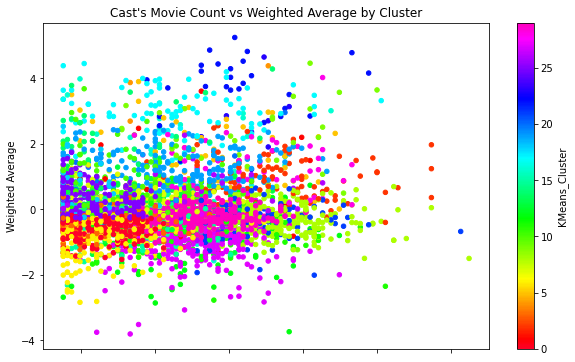

In [ ]:
X_train_num.plot.scatter('cast_movie_count', 'weighted_average', c=cluster_type, colormap='gist_rainbow',
                         title="Cast's Movie Count vs Weighted Average by Cluster", figsize=(10,6)).set(xlabel="Cast's Movie Count", ylabel="Weighted Average");

It seems like our model was able to catch the clusters with some accuracy. This is expected. Since our data is high dimensional, it is hard to seperate the clusters by just two features.

This function gets a movie name and finds its cluster. We also have some input check processes in case there are multiple movies with the same name, or if the movie name was not in our dataset.

In [ ]:
import random

def select_c(cluster_type):
    global movie_title_c
    global movie_title_year_c
    global movie_title
    global movie_year
    global isDuplicate
    isDuplicate=False
    movie_title = input('Please enter the title of the movie you want recommendations for:')
    if new_data[new_data["title"]==movie_title].value_counts().sum() ==1 :
      movie_title_c = new_data[cluster_type][new_data.title == movie_title]
    else:
      while new_data[new_data["title"]==movie_title].value_counts().sum() ==0 or new_data[new_data["title"]==movie_title].value_counts().sum()>1:
        if new_data[new_data["title"]==movie_title].value_counts().sum() >1 :
          print('There are multiple movies with the same name.')
          mymovie = new_data[new_data["title"]==movie_title]
          for movie in mymovie.index:
            print(movie_title, " (", mymovie.loc[movie].year,") dir. ", mymovie.loc[movie].director, sep="")
          movie_year = input('Please enter the year of the movie:')
          movie_title_year_c= new_data[cluster_type][(new_data.year == int(movie_year))&
                                                  (new_data.title == movie_title)]
          isDuplicate=True
          break
        elif new_data[new_data["title"]==movie_title].value_counts().sum() ==0 :
          print('This movie does not exist in our database!')
          movie_title = input('Please enter the title of the movie you want recommendations for:')
      movie_title_c = new_data[cluster_type][new_data.title == movie_title]   



This function prints 5 movies that are in the same cluster with the chosen movie.

In [ ]:
def main(cluster_type):
    ans = False
    a = 5
    while not ans:
        select_c(cluster_type)
        if isDuplicate:
          print(new_data['title'][new_data[cluster_type] == int(movie_title_year_c)].sample(n=a))
        else:
          print(new_data['title'][new_data[cluster_type] == int(movie_title_c)].sample(n=a))
        print('--------------------------------------------------------------------')
        print('Do you like these movies(y/n)')
        abc = input()
        while ((abc =='y') or (abc == 'Y')):
          if isDuplicate:
            print(new_data['title'][new_data[cluster_type] == int(movie_title_year_c)].sample(n=a))
          else:          
            print(new_data['title'][new_data[cluster_type] == int(movie_title_c)].sample(n=a))
          print('--------------------------------------------------------------------')
          print('Want more!!!!(y/n)')
          abc = input()
          if ((abc =='N') or (abc == 'n')):
              ans =True

Let's check our recommenations with KMeans Model.

In [ ]:
main(cluster_type)

Please enter the title of the movie you want recommendations for:Home Alone
2455                   Creepshow
1847             Dressed to Kill
338                 Evil Dead II
1271    The Last of the Mohicans
175           Driving Miss Daisy
Name: title, dtype: object
--------------------------------------------------------------------
Do you like these movies(y/n)
y
288       From Russia with Love
1893    My Beautiful Laundrette
272                      Grease
819                 Beetlejuice
109                 Stand by Me
Name: title, dtype: object
--------------------------------------------------------------------
Want more!!!!(y/n)
n


These recommendations do not seem very accurate. Home Alone is a family/comedy movie, whereas our model recommended a horror movie (Evil Dead II).

#### Agglomerative Model with Gower's Distance
Now, we will implement another Agglomerative Model using Gower's Distance. This will enable us to use mixed data. So, along with our continous data we listed earlier, we will be able to use our binary genre data. This data tells us whether a movie is a comedy, horror, drama, etc movie.

We prepare the data, implement the model and assign clusters to each data point.


In [ ]:
X_train_num= X_train.drop(["genres", "keywords","title","director","cast_1","cast_2","cast_3","production_companies_1"], axis = 1)

scaler = StandardScaler()

X_train_num_wout_id = scaler.fit_transform(X_train_num.drop(columns=["movie_id"]))
X_train_num_wout_id = pd.DataFrame(X_train_num, 
                                   columns = X_train_num.drop(columns=["movie_id"]).columns, index = X_train_num.index)

We get the distance matrix of our data using Gower's distance, and run our model.

In [ ]:
import gower
from sklearn.cluster import AgglomerativeClustering
distanceMatrix = gower.gower_matrix(X_train_num_wout_id)

agglomerative_with_gower_model = AgglomerativeClustering(n_clusters = 30, affinity= 'precomputed', linkage= 'complete')

agglomerative_with_gower_model.fit(distanceMatrix)
label = agglomerative_with_gower_model.labels_

In [ ]:
sscore = silhouette_score(distanceMatrix, label, metric='precomputed')
print(f'Silhouette Score(n=30): {sscore}')

Silhouette Score(n=30): 0.13172557950019836


The silhouette score has increased an insignificant amount (~0.6%).

In [ ]:
cluster_type = "Gower_Clustering"

X_train_num = X_train_num_wout_id.join(X_train_num["movie_id"])               
X_train_num[cluster_type] = agglomerative_with_gower_model.labels_
X_train_num[cluster_type].sample(n=10)

e = []
def fi(group):
    a = pd.DataFrame(group)
    b = pd.DataFrame(a[cluster_type].value_counts())
    d = a.index 
    c = [a['movie_id'][d[0]],int(b.idxmax())]
    e.append(c)

X_train_num.groupby("movie_id").apply(lambda x: fi(x))

e = pd.DataFrame(e)
e.rename(columns = {0:'movie_id',1:cluster_type},inplace=True)
e.drop_duplicates(inplace=True)

new_data = pd.merge(e , X_train , how='outer', on='movie_id')

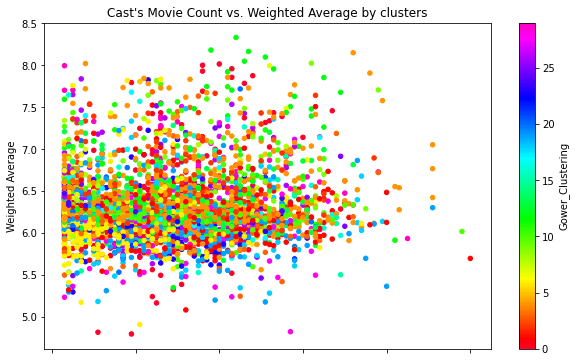

In [ ]:
X_train_num.plot.scatter('cast_movie_count', 'weighted_average', c=cluster_type, colormap='gist_rainbow', figsize=(10,6),
                         title="Cast's Movie Count vs. Weighted Average by clusters").set(xlabel="Cast's Movie Count",
                        ylabel="Weighted Average");

Now, attempts to visualize suffer even more from high dimensionality. The clusters are not seperable by two features.

In [ ]:
main(cluster_type)

Please enter the title of the movie you want recommendations for:Home Alone
405               The Flintstones
1758               Daddy Day Care
2233    Christmas with the Kranks
1370            Super Mario Bros.
1901                 Nanny McPhee
Name: title, dtype: object
--------------------------------------------------------------------
Do you like these movies(y/n)
y
684                      Lost in Space
1688                    102 Dalmatians
3636    Diary of a Wimpy Kid: Dog Days
749                      Evan Almighty
2662               Aliens in the Attic
Name: title, dtype: object
--------------------------------------------------------------------
Want more!!!!(y/n)
n


The recommendations are much better! Most of the movies are comedy / family movies.

#### KMeans Model with Principal Component Analysis

We believe that previous models suffered a lot from the high dimensionality of our data. Therefore we are going to do a principal component analysis in order to overcome this problem.

Here we prepare our dataset and PCA.

In [ ]:
X_train_num= X_train.drop(["genres", "keywords","title","director","cast_1","cast_2","cast_3","production_companies_1"], axis = 1)

scaler = StandardScaler()

X_train_num_wout_id = scaler.fit_transform(X_train_num.drop(columns=["movie_id"]))
X_train_num_wout_id = pd.DataFrame(X_train_num_wout_id, 
                                   columns = X_train_num.drop(columns=["movie_id"]).columns, index = X_train_num.index)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_train_num_wout_id)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

We run our KMeans model with the data we processed. 

In [ ]:
kmeanModel = KMeans(n_clusters=30)
kmeanModel.fit(principalDf)
cluster_type = "KMeans_Cluster"

cluster_type = "PCA_Cluster"
X_train_num = X_train_num_wout_id.join(X_train_num["movie_id"])               
X_train_num[cluster_type] = kmeanModel.labels_

e = []
def fi(group):
    a = pd.DataFrame(group)
    b = pd.DataFrame(a[cluster_type].value_counts())
    d = a.index 
    c = [a['movie_id'][d[0]],int(b.idxmax())]
    e.append(c)

X_train_num.groupby("movie_id").apply(lambda x: fi(x))

e = pd.DataFrame(e)
e.rename(columns = {0:'movie_id',1:cluster_type},inplace=True)
e.drop_duplicates(inplace=True)

new_data = pd.merge(e , X_train , how='outer', on='movie_id')

In [ ]:
label=kmeanModel.predict(principalDf)
print(f'Silhouette Score(n=30): {silhouette_score(principalDf, label)}')

Silhouette Score(n=30): 0.33086069244959937


The silhouette score has significantly increased after applying PCA to our dataset.

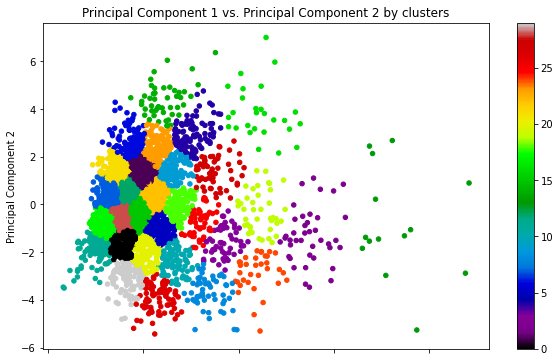

In [ ]:
principalDf.plot.scatter('principal component 1', 'principal component 2', c=label, colormap='nipy_spectral', figsize=(10, 6),
                         title="Principal Component 1 vs. Principal Component 2 by clusters").set(xlabel="Principal Component 1",
                        ylabel="Principal Component 2")
plt.show();

The clusters are much clearer when compared to previous models. Applying PCA, we reduced the dimensionality of the data. Therefore we can see the clusters clearly and have higher silhouette score.

In [ ]:
main(cluster_type)

Please enter the title of the movie you want recommendations for:Home Alone
1988              Mamma Mia!
1428                Bad Boys
586                    Dogma
530         Meet the Parents
625     The Butterfly Effect
Name: title, dtype: object
--------------------------------------------------------------------
Do you like these movies(y/n)
y
521            The Holiday
1764               Firefox
315     For Your Eyes Only
586                  Dogma
1988            Mamma Mia!
Name: title, dtype: object
--------------------------------------------------------------------
Want more!!!!(y/n)
n


The recommendations are worse. We think this might be caused by the fact that PCA gives equal importance to each feature. This could mean that budget has the same effect on the clustering with genres. But genres are actually much more important than the budget, runtime or popularity of a movie.

#### Cosine Similarity Function

Our cosine similarity function calculates how similar given inputs are based on their non-numerical attributes. We add all of these features into a soup feature and we will make our calculations based on that.

Our non-numerical features are:
- Genres
- Keywords
- Director
- Cast
- Production Company

We get lists from the dictionaries. Later, we will add those together in soup strings and compute the similarities.

In [ ]:
df_movies['genres'] = df_movies['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
df_movies['keywords'] = df_movies['keywords'].apply(literal_eval)
df_movies['keywords'] = df_movies['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

Using snowball stemmer, we can group similar words and reduce them to their stems. For example, we gather words like "fairly" and "fair" into the same stem, which allows us to be more precise.

In [ ]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer('english')
df_movies['keywords'] = df_movies['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
df_movies['keywords'] = df_movies['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

First, we count how many times each keyword appears in the keywords list. Then we remove the words with least frequency from the lists.

In [ ]:
s = df_movies.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'
s = s.value_counts()

s = s[s > 1]
def filter_keywords(x):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words

df_movies['keywords'] = df_movies['keywords'].apply(filter_keywords)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


Some columns (*cast_1, director, production companies,* etc.) have single strings. To be able to process them together with lists in the other columns, we need to turn the former ones into lists as well.

In [ ]:
df_movies['cast_1'] = df_movies['cast_1'].apply(lambda x: [x])
df_movies['director'] = df_movies['director'].apply(lambda x: [x])
df_movies['cast_2'] = df_movies['cast_2'].apply(lambda x: [x])
df_movies['cast_3'] = df_movies['cast_3'].apply(lambda x: [x])
df_movies["production_companies_1"] = df_movies["production_companies_1"].apply(lambda x: [x])

We add the lists together in a single list and then convert the soup list into a soup string.

In [ ]:
df_movies['soup'] = df_movies['keywords'] + df_movies['cast_1'] + df_movies['cast_2'] + df_movies['cast_3'] + df_movies['director']+ df_movies['genres'] + df_movies["production_companies_1"]
df_movies['soup'] = df_movies['soup'].apply(lambda x: ' '.join(x))

We use a count vectorizer to count the occurences of each word and calculate the similarities using a cosine similarity function.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(df_movies['soup'])

cosine_sim = cosine_similarity(count_matrix, count_matrix)

We use the results of the cosine similarity function to find movies that are similar. We sort the list in decreasing order to get most similar movies.

In [ ]:
df_movies = df_movies.reset_index()
titles = df_movies['title']
indices = pd.Series(df_movies.index, index=df_movies['title'])

def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

Because our similarity function calculates the similarities of the soup strings, we are not able to measure or visualize the performance our function.

We recommend the first ten movies in our similarity lists. Since the list was sorted, best recommendations are printed first.

In [ ]:
get_recommendations("Home Alone").head(10)

2077    Home Alone 2: Lost in New York
1806                    Mrs. Doubtfire
989                     Baby's Day Out
921                    We Bought a Zoo
2543             Because of Winn-Dixie
1928                   Say It Isn't So
1068                        Fat Albert
727                 Jingle All the Way
926                           Garfield
966                          Marmaduke
Name: title, dtype: object

The recommendations seem much better!

### Results & Discussion

First, comparing our K-Means model which we used only numerical features and our Agglomerative model with Gower's Distance, including genres as features improved the performance of our models when recommending movies. On the other hand, this did not result in an increase in silhouette score of the models.

A reason why our K-Means model with PCA has failed when recommending movies could be the fact that we did not assign importances to our features. That could improve the performance of the model. Still, the improvements in the silhouette score and visualization are significant.

After observing our machine learning models and similarity function, we can say that the similarity function works better than the machine learning models when recommending movies. This could imply that the relationships between movies can be discovered better using categorical attributes rather than numerical attributes when user-specific information is not available.



## Conclusion

We had two questions in the beginning and they were:
1. How are movies related by their numerical attributes? (e.g. budget, revenue and popularity)
2. How are movies related by their non-numerical attributes? (e.g. director, genre and cast)

In our work, we tried to understand how we can interpret our data through visualization and models. We ran several clustering models for numerical values, and mixed-data. Then we tried to find the similarity of movies with our cosine similarity function. It is obvious that there is room for improvement. Nevertheless they are accurate to a fine degree, and we have meaningful outputs.

Movies seem to be related more with their non-numerical attributes when compared with the numerical ones. Also, it is important to set the importances of genres when working them with features like budget and popularity.

## Future Work

We believe that our work has resulted in an understanding that could be used as a base for further developments. The importances of the machine learning models could be tweaked to enhance the performance. Also, the performance of the similarity function can be visualized using advanced techniques.

## Work Division

In the **Introduction** part:
- Bengisu and İdil worked on writing the background and rationale, 
- Gönül was responsible of the description of the problem,
- Dora downloaded and transfered the data from Kaggle using Kaggle's API. 
- Description of the dataset was discussed and done together.

In the **Data Exploration** part:
- İdil and Gönül worked on data visualization and plotted several graphs. They edited the plots and looked for ways for us to visualize our data in a meaningful way.
- Dora worked on feature extraction. He transformed the categorical data into binary.
- Bengisu plotted several graphs and worked on removing outliers.

In the **Machine Learning Models** part:
- Dora and Bengisu implemented the Machine Learning Models. They worked together in both Cosine Similarity Function and K-Means Clustering Model.
- İdil, Dora and Gönül worked on Gower's Distance for Agglomerative Models.

In general, reviewing and editing was done with teamwork and all members contributed actively.